Example notebook to showcase the use of the eccDefinition module. Please do not commit your local changes

**NOTE**: Need to set "LAL_DATA_PATH" before launching this notebook

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")

from measureEccentricity.measureEccentricity import get_available_methods
from measureEccentricity import measure_eccentricity
from measureEccentricity.load_data import load_waveform

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


### Currently implemented methods

Let's start by seeing which methods are currently implemented

In [10]:
available_methods = list(get_available_methods().keys())
print (available_methods)

['Amplitude', 'Frequency', 'ResidualAmplitude']


In the following, we will use these different methods and show what the measured eccentricity looks like. The wrapper function, measure_eccentricity, allows you to easily switch between methods.

In [2]:
help(measure_eccentricity)

Help on function measure_eccentricity in module measureEccentricity.measureEccentricity:

measure_eccentricity(tref_in, dataDict, method='Amplitude', return_ecc_method=False, spline_kwargs=None, extra_kwargs=None)
    Measure eccentricity and mean anomaly at reference time.
    
    parameters:
    ----------
    tref_in:
        Input reference time at which to measure eccentricity and mean anomaly.
        Can be a single float or an array. NOTE: eccentricity/mean_ano are
        returned on a different time array tref_out, described below.
    
    dataDict:
        Dictionary containing waveform modes dict, time etc.
        Should follow the format:
            {"t": time, "hlm": modeDict, ...}
            with modeDict = {(l1, m1): h_{l1, m1},
                             (l2, m2): h_{l2, m2}, ...
                            }.
        Some methods may need extra data. For example, the ResidualAmplitude
        method, requires "t_zeroecc" and "hlm_zeroecc" as well in dataDict.
 

### Loading waveform data

Let's now get some waveform data in the required format, using the handy load_waveform function.

Waveform data are to be provided as a dictionary of different variables. In most cases, the required ones would be the time array and the dictionary of different modes. load_waveform function returns such a dictionary that could be directly used in the measure_eccentricity wrapper function.

In [3]:
help(load_waveform)

Help on function load_waveform in module measureEccentricity.load_data:

load_waveform(catalog='LAL', **kwargs)
    Load waveform from lvcnr file or LAL.
    
    parameters:
    ----------
    catalog:
          Waveform type. could be one of 'LAL', 'LVCNR', EOB
    
    kwargs:
         Kwargs to be passed to the waveform loading functions.



Here is an example of how to load a LAL waveform

In [4]:
# Let's try a PN eccentric model
# We use the keyword "include_zero_ecc" as we want to use the residual amplitude 
# method that needs data for the zero eccentricity counterpart as well
waveform_keywords = {"approximant": "EccentricTD",
                     "q": 1.0,
                     "chi1": [0.0, 0.0, 0.0],
                     "chi2": [0.0, 0.0, 0.0],
                     "deltaTOverM": 0.1,
                     "Momega0": 0.01,
                     "ecc": 0.1,
                     "mean_ano": 0,
                     "phi_ref": 0,
                     "inclination": 0,
                     "include_zero_ecc": True}
dataDict = load_waveform(catalog="LAL", **waveform_keywords)

We can use the data and see how the amplitude looks

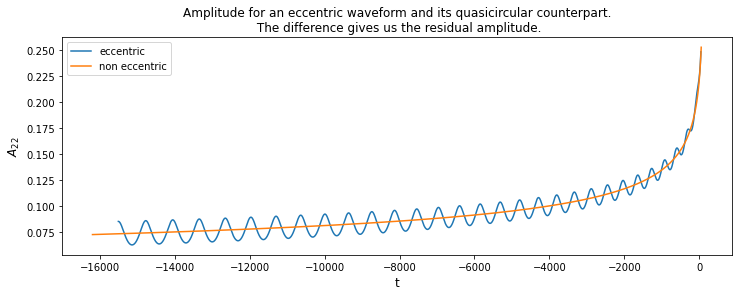

In [5]:
plt.figure(0, figsize=(12, 4))
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="eccentric")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="non eccentric")
plt.xlabel('t', fontsize=12)
plt.ylabel('$A_{22}$', fontsize=12)
plt.title('Amplitude for an eccentric waveform and its quasicircular counterpart.\n '
          'The difference gives us the residual amplitude.')
plt.legend();

### Measure eccentricity at a given tref

Now that we have our dataDict ready, let's see how to use it in the measure_eccentricity wrapper function. Below we show how to get the eccentricity and mean anomaly at a given reference time.

In [6]:
# Use the measure_eccentricity with your favorite method to 
# compute ecc and mean_ano at a given tref
tref = -12000
tref_out, ecc, mean_ano = measure_eccentricity(tref, dataDict, method="Amplitude")
print (f"ecc={ecc:.3f} and mean_ano={mean_ano:.3f} at tref={tref}")

ecc=0.104 and mean_ano=5.951 at tref=-12000


We can try all the methods that are currently implemented

In [8]:
tref = -12000
for method in get_available_methods():
    tref_out, ecc, mean_ano = measure_eccentricity(tref, dataDict, method="Amplitude")
    print (f"method={method}: ecc={ecc:.3f} and mean_ano={mean_ano:.3f} at tref={tref}")

method=Amplitude: ecc=0.104 and mean_ano=5.951 at tref=-12000
method=Frequency: ecc=0.104 and mean_ano=5.951 at tref=-12000
method=ResidualAmplitude: ecc=0.104 and mean_ano=5.951 at tref=-12000


### Measure eccentricity and mean anamoly at reference times

Instead of measuring the eccentricity and mean anomaly at a single reference time, we might be interested in seeing how the eccentricity and mean anomaly varies with time.

For this, we simply pass the reference time array where we want to measure the eccentricity and the mean anomaly. We call this time array $t^\text{ref}_\text{in}$. The `measure_eccentricity` function then returns the measured values of eccentricity and mean anomaly and the time array $t^\text{ref}_\text{out}$ where these values are measured.

Note that $t^\text{ref}_\text{out}$ might **NOT** be the same as $t^\text{ref}_\text{in}$. It would depend on few factors.
- $t^\text{ref}_\text{out}$ is basically $t^\text{ref}_\text{in}[t^\text{ref}_\text{in} \geq t_\text{min} \text{ and } t^\text{ref}_\text{in} < t_\text{max}]$ where $t_\text{min} = max(t_\text{peaks}[0], t_\text{troughs}[0])$ and $t_\text{max} = min(t_\text{peaks}[-1], t_\text{troughs}[-1])$. This makes sure that no extrapolation happens when measuring the eccentricity and mean anomaly. Currently this is done only when `num_orbits_to_exclude_before_merger` is non negative real number.
- It is observed that if the extrema interpolator uses the extrema points very close to the merger then it shows some unphysical features like non-monotonicity in the eccentricity when plotted as a function of time. This is why it might be good to leave  one or more peaks that is close to the merger. This is what the `num_orbits_to_exclude_before_merger` is used for. By default it is set to 1.

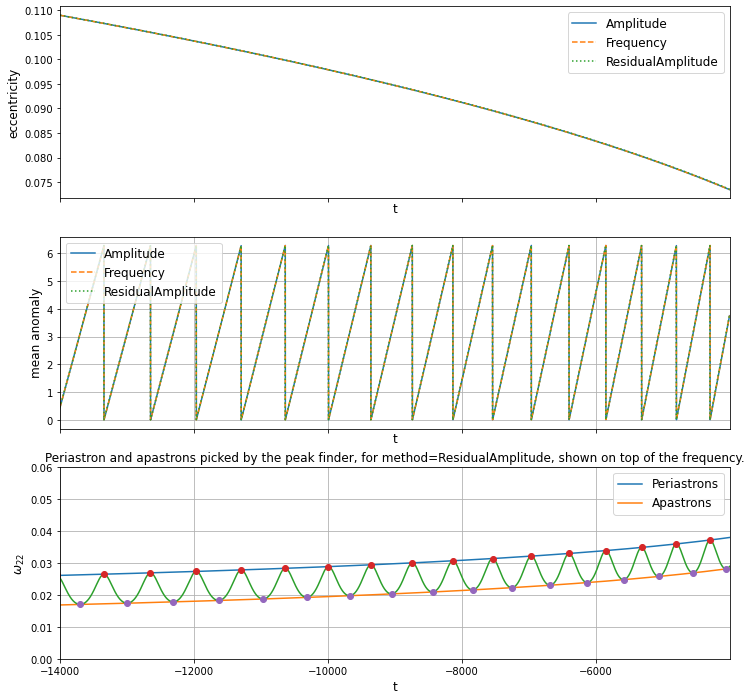

In [11]:
# refernce times at which to measure eccentricity and mean anomaly
tref_vec = np.arange(-14000, -4000)

fig, axarr = plt.subplots(nrows=3, sharex=True, figsize=(12, 12))
for method in available_methods:
    tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDict, method=method, 
                                                                      return_ecc_method=True,
                                                                     extra_kwargs={"debug": False})
    if method == available_methods[0]:
        ls = 'solid'
    elif method == available_methods[1]:
        ls = 'dashed'
    else:
        ls = 'dotted'
    axarr[0].plot(tref_vec, ecc_vec, label=method, ls=ls)
    axarr[1].plot(tref_vec, mean_ano_vec, label=method, ls=ls)
    
    if method == available_methods[-1]:
        # Plot omega(t) and peaks/troughs only for one case
        axarr[2].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
        axarr[2].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
        axarr[2].plot(eccMethod.t, eccMethod.omega22)
        axarr[2].plot(eccMethod.t[eccMethod.peaks_location], 
                      eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
        axarr[2].plot(eccMethod.t[eccMethod.troughs_location], 
                      eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")
        axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
                            f'for method={method}, shown on top of the frequency.', fontsize=12);

axarr[0].set_xlabel("t", fontsize=12)
axarr[1].set_xlabel("t", fontsize=12)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[1].grid()
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=12)
axarr[2].set_ylim(0, 0.06)
axarr[2].set_xlim(min(tref_vec), max(tref_vec))
axarr[2].set_xlabel("t", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].grid()
axarr[2].legend(fontsize=12);

### Working on SXS waveform

Now let's look at one of the SXS waveforms

In [12]:
import glob

In [13]:
SXS_Files = glob.glob("/home1/md.shaikh/etask_force/AEI_sxs_sims/*.h5")

In [17]:
sxs_kwargs = {"filepath": SXS_Files[3], "include_zero_ecc": True}

In [18]:
dataDictSXS = load_waveform("LVCNR", **sxs_kwargs)
SXS_Files[3]

'/home1/md.shaikh/etask_force/AEI_sxs_sims/BBH_SHK_q4_e035_D26_Res3.h5'

In [27]:
tref_vec = np.arange(-12000, -100)
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDictSXS,"Amplitude",
                                                        return_ecc_method=True,
                                                        spline_kwargs={"k": 3},
                                                        extra_kwargs={"extrema_finding_kwargs": {"width": 100}})

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:323: UserWarning: time array t_for_ecc_test is too long. Length is 117330
  


Note that we use `return_ecc_method=True` so that it returns the `eccMethod` object that is used to measure the eccentricity and mean anomaly in the `measure_eccentricity` wrapper function. We can use this object to access almost all the necessary data that goes into the eccentricity measurement.

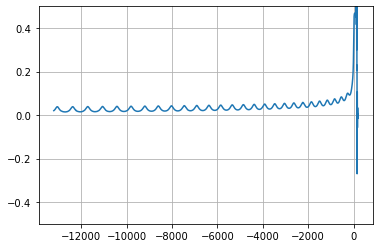

In [28]:
plt.plot(eccMethod.t, eccMethod.omega22)
plt.ylim(-0.5, 0.5)
plt.grid()

Below we plot differenct quantities to asses how well our eccentricity measurment method is working. This could be seen as a diagnostic tool to check an implemented method.

We plot the following quantities
- The eccentricity vs $t^\text{ref}_\text{out}$
- $de/dt$ vs time, this is to test the monotonicity of eccentricity as a function of time
- mean anomaly vs $t^\text{ref}_\text{out}$
- $\omega_{22}$ vs $t^\text{ref}_\text{out}$ with the peaks and troughs shown. This would show if the method is missing any peaks/troughs or selecting one which is not a peak/trough and finally
- ratio of $\Delta\phi_\text{orb}$ at an extrema to the previous one as function times at extrema. This is to check if two peaks/troughs are too far or too close. This would singal missing extrema or false extrema.

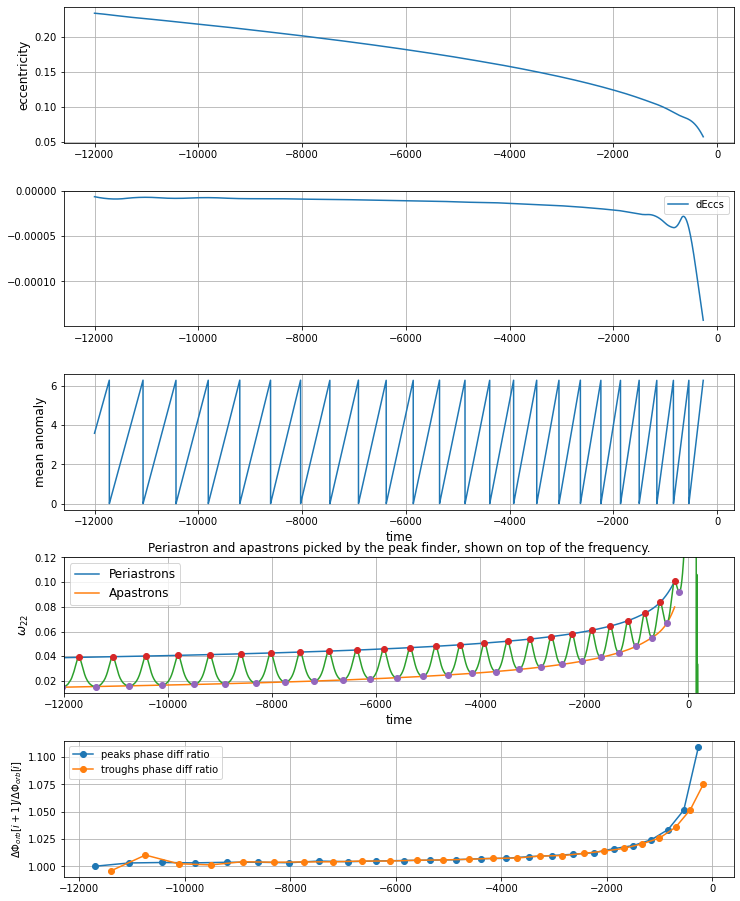

In [32]:
fig, axarr = plt.subplots(nrows=5, figsize=(12, 16))
axarr[0].plot(tref_out, ecc_vec)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[0].grid()

axarr[1].plot(eccMethod.t_for_ecc_test, eccMethod.decc_dt, label="dEccs")
axarr[1].legend()
axarr[1].grid()

axarr[2].plot(tref_out, mean_ano_vec)
axarr[2].set_xlabel("time", fontsize=12)
axarr[2].set_ylabel("mean anomaly", fontsize=12)
axarr[2].grid()

axarr[3].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
axarr[3].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
axarr[3].plot(eccMethod.t, eccMethod.omega22)
axarr[3].plot(eccMethod.t[eccMethod.peaks_location], eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
axarr[3].plot(eccMethod.t[eccMethod.troughs_location], eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")

axarr[3].set_ylim(0.01, 0.12)
axarr[3].set_xlim(min(tref_vec),)
axarr[3].set_xlabel("time", fontsize=12)
axarr[3].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[3].grid()
axarr[3].legend(fontsize=12)
axarr[3].set_title('Periastron and apastrons picked by the peak finder, '
          'shown on top of the frequency.', fontsize=12);

tpeaks = eccMethod.t[eccMethod.peaks_location[1:]]
axarr[4].plot(tpeaks[1:], eccMethod.orb_phase_diff_ratio_at_peaks[1:], marker="o", label="peaks phase diff ratio")
ttroughs = eccMethod.t[eccMethod.troughs_location[1:]]
axarr[4].plot(ttroughs[1:], eccMethod.orb_phase_diff_ratio_at_troughs[1:], marker="o", label="troughs phase diff ratio")
axarr[4].set_ylabel("$\Delta \Phi_{orb}[i+1] / \Delta \Phi_{orb}[i]$")
axarr[4].grid()
axarr[4].legend()
plt.subplots_adjust(hspace=0.35)

### setting `num_orbits_to_exclude_before_merger` to 0

By default it is set to 1. Which implies that the data only upto 1 orbits before the merger is used when finding the peaks and troughs. However if we set it to 0, it will use data all the way up to the merger and hence it would detect merger as a peak. Let's see how the above plots change with this change of `num_orbits_to_exclude_before_merger` to 0

In [33]:
tref_vec = np.arange(-12000, -100)
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDictSXS,"Amplitude",
                                                        return_ecc_method=True,
                                                        spline_kwargs={"k": 3},
                                                        extra_kwargs={"extrema_finding_kwargs": {"width": 100},
                                                                     "num_orbits_to_exclude_before_merger": 0})

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:290: UserWarning: At least a pair of peaks are too far. Maximum orbital phase diff is 16.74330564859892. Times of occurances are [0.00245741]
  f"{max(orb_phase_diff)}. Times of occurances are"
/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:323: UserWarning: time array t_for_ecc_test is too long. Length is 118250
  
/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:333: UserWarning: Ecc(t) is non monotonic.
  # Is ecc(t) a convex function? That is, is the second


We immediately notice two warnings:
- First one says that at least a pair of peaks are too far, i.e., the phase diff at some peak is atleast 1.5 times the phase diff at the previous peak. Here we see that actual the phase difference between two peaks is about 17 ~ 5 pi. This implies that a peak is probably missed by the method.
- Last one says that ecc is non monotonic, this is because now the extrema interpolation uses a peak close to the merger and hence the interpolation show weird feature.

Lets see how these are reflected in the diagnostic plots

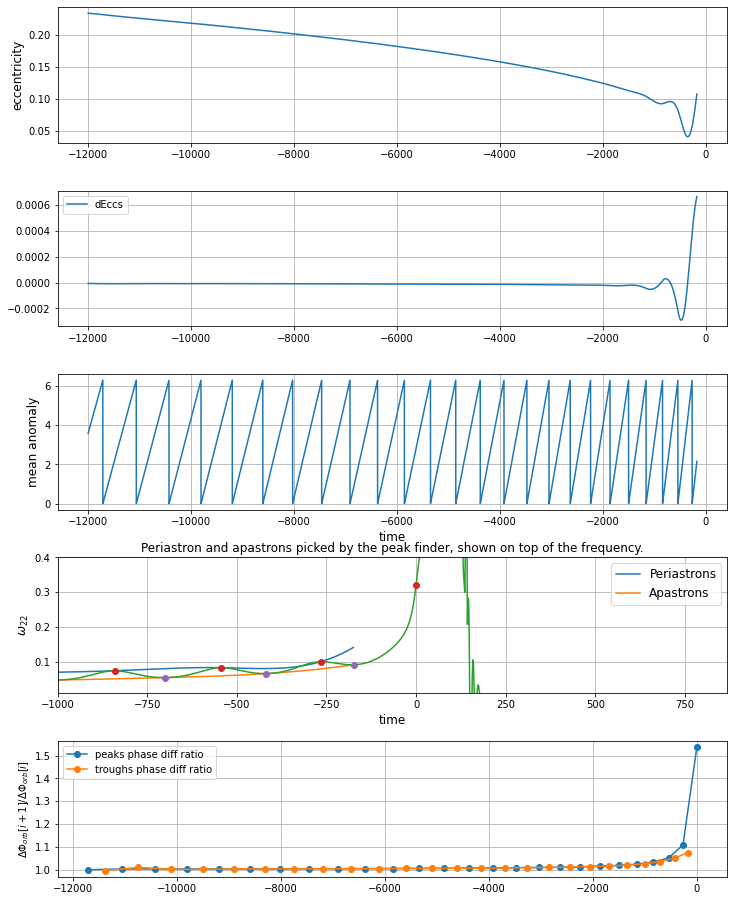

In [39]:
fig, axarr = plt.subplots(nrows=5, figsize=(12, 16))
axarr[0].plot(tref_out, ecc_vec)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[0].grid()

axarr[1].plot(eccMethod.t_for_ecc_test, eccMethod.decc_dt, label="dEccs")
axarr[1].legend()
axarr[1].grid()

axarr[2].plot(tref_out, mean_ano_vec)
axarr[2].set_xlabel("time", fontsize=12)
axarr[2].set_ylabel("mean anomaly", fontsize=12)
axarr[2].grid()

axarr[3].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
axarr[3].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
axarr[3].plot(eccMethod.t, eccMethod.omega22)
axarr[3].plot(eccMethod.t[eccMethod.peaks_location], eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
axarr[3].plot(eccMethod.t[eccMethod.troughs_location], eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")

axarr[3].set_ylim(0.01, 0.4)
axarr[3].set_xlim(-1000,)
axarr[3].set_xlabel("time", fontsize=12)
axarr[3].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[3].grid()
axarr[3].legend(fontsize=12)
axarr[3].set_title('Periastron and apastrons picked by the peak finder, '
          'shown on top of the frequency.', fontsize=12);

tpeaks = eccMethod.t[eccMethod.peaks_location[1:]]
axarr[4].plot(tpeaks[1:], eccMethod.orb_phase_diff_ratio_at_peaks[1:], marker="o", label="peaks phase diff ratio")
ttroughs = eccMethod.t[eccMethod.troughs_location[1:]]
axarr[4].plot(ttroughs[1:], eccMethod.orb_phase_diff_ratio_at_troughs[1:], marker="o", label="troughs phase diff ratio")
axarr[4].set_ylabel("$\Delta \Phi_{orb}[i+1] / \Delta \Phi_{orb}[i]$")
axarr[4].grid()
axarr[4].legend()
plt.subplots_adjust(hspace=0.35)

Lets repeat this with `ResidualAmplitude` Method

In [40]:
tref_vec = np.arange(-12000, -100)
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDictSXS,"ResidualAmplitude",
                                                        return_ecc_method=True,
                                                        spline_kwargs={"k": 3},
                                                        extra_kwargs={"extrema_finding_kwargs": {"width": 100},
                                                                     "num_orbits_to_exclude_before_merger": 0})

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:323: UserWarning: time array t_for_ecc_test is too long. Length is 118990
  
/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:333: UserWarning: Ecc(t) is non monotonic.
  # Is ecc(t) a convex function? That is, is the second


Note that the warning about at least a pair of peaks being too far is no more there. In the $\omega_{22}$ plot below, we can see that `ResidualAmplitude` method detects a new peak in between the last two peaks of the above plot. This show how `ResidualAmplitude` works better than `Amplitude` method.

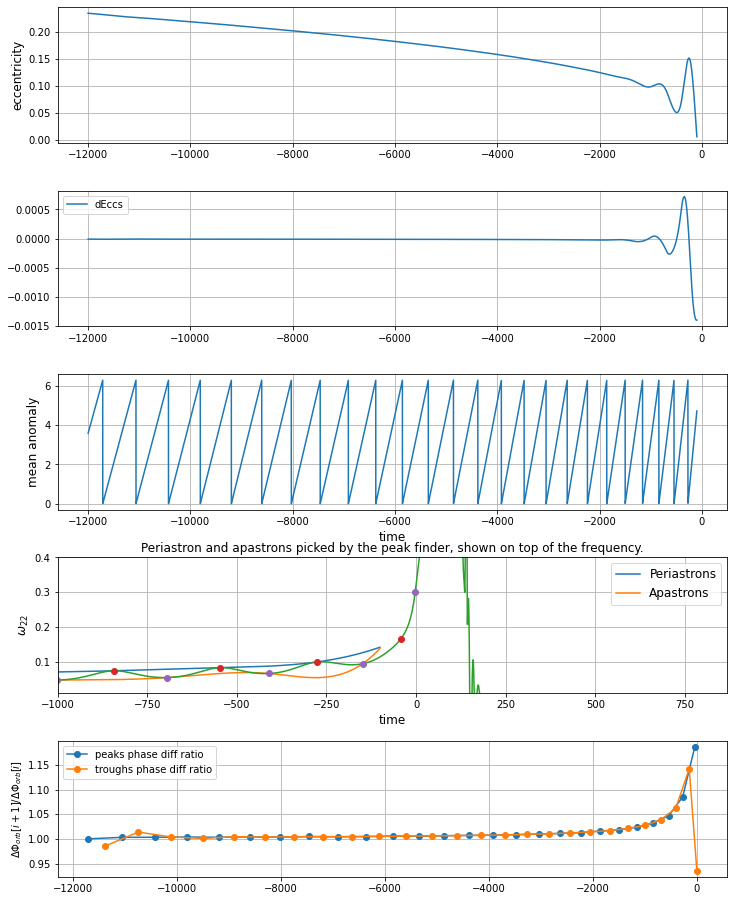

In [41]:
fig, axarr = plt.subplots(nrows=5, figsize=(12, 16))
axarr[0].plot(tref_out, ecc_vec)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[0].grid()

axarr[1].plot(eccMethod.t_for_ecc_test, eccMethod.decc_dt, label="dEccs")
axarr[1].legend()
axarr[1].grid()

axarr[2].plot(tref_out, mean_ano_vec)
axarr[2].set_xlabel("time", fontsize=12)
axarr[2].set_ylabel("mean anomaly", fontsize=12)
axarr[2].grid()

axarr[3].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
axarr[3].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
axarr[3].plot(eccMethod.t, eccMethod.omega22)
axarr[3].plot(eccMethod.t[eccMethod.peaks_location], eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
axarr[3].plot(eccMethod.t[eccMethod.troughs_location], eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")

axarr[3].set_ylim(0.01, 0.4)
axarr[3].set_xlim(-1000,)
axarr[3].set_xlabel("time", fontsize=12)
axarr[3].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[3].grid()
axarr[3].legend(fontsize=12)
axarr[3].set_title('Periastron and apastrons picked by the peak finder, '
          'shown on top of the frequency.', fontsize=12);

tpeaks = eccMethod.t[eccMethod.peaks_location[1:]]
axarr[4].plot(tpeaks[1:], eccMethod.orb_phase_diff_ratio_at_peaks[1:], marker="o", label="peaks phase diff ratio")
ttroughs = eccMethod.t[eccMethod.troughs_location[1:]]
axarr[4].plot(ttroughs[1:], eccMethod.orb_phase_diff_ratio_at_troughs[1:], marker="o", label="troughs phase diff ratio")
axarr[4].set_ylabel("$\Delta \Phi_{orb}[i+1] / \Delta \Phi_{orb}[i]$")
axarr[4].grid()
axarr[4].legend()
plt.subplots_adjust(hspace=0.35)